# Langkah 1: Import Library dan Mount Google Drive

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models



2025-12-16 18:20:04.825675: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-16 18:20:04.862603: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-16 18:20:05.500023: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-16 18:20:05.500023: I tensorflow/core/util/port.cc:153] oneD

# Langkah 2: Load Dataset

In [2]:
# Load images and labels from a directory structure
def load_dataset(img_dir):
    p = Path(img_dir)
    img_list = []
    for folder in p.glob('*'):
        label = folder.name
        for file in folder.glob('*.jpg'):
            img = cv2.imread(str(file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_list.append((img, label))
    return img_list

train_dir = "dataset/training/"
test_dir  = "dataset/test/"

train_img = load_dataset(train_dir)
test_img  = load_dataset(test_dir)

print(f"Jumlah data training: {len(train_img)}")
print(f"Jumlah data testing: {len(test_img)}")

Jumlah data training: 240
Jumlah data testing: 160


# Langkah 3: Preprocessing (Resize & Label Encoding)

In [3]:
# Preprocess images: resize and encode labels
def resize_image(img, size=(256,256)):
    return cv2.resize(img, size)

def label_encoder(label):
    return 1 if label == 'day' else 0

def preprocess(img_list):
    X = []
    y = []
    for img, label in img_list:
        img_std = resize_image(img)
        X.append(img_std)
        y.append(label_encoder(label))
    return X, y

X_train_img, y_train = preprocess(train_img)
X_test_img,  y_test  = preprocess(test_img)

# Langkah 4: Ekstraksi Fitur HOG (Histogram of Oriented Gradients)

In [4]:
# Extract HOG features
def extract_hog(X_imgs):
    feats = []
    for img in X_imgs:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hog_feat = hog(gray,
                       orientations=9,
                       pixels_per_cell=(8,8),
                       cells_per_block=(2,2),
                       block_norm='L2-Hys',
                       visualize=False,
                       feature_vector=True)
        feats.append(hog_feat)
    return np.array(feats)

X_train_feat = extract_hog(X_train_img)
X_test_feat  = extract_hog(X_test_img)

# Langkah 5: Normalisasi Fitur

In [5]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_test_scaled  = scaler.transform(X_test_feat)

# Langkah 6: Split Data Training & Validation

In [6]:
# Split training data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_scaled, y_train,
    test_size=0.2,
    random_state=42
)

# Langkah 7: Konversi Label ke Numpy Array

In [7]:
# Convert labels to numpy arrays (required for Keras)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Langkah 8: Membangun Arsitektur Model Neural Network

In [8]:
# Build a simple feedforward neural network
# Define model architecture
# input_dim is the number of features in the dataset
# Hidden layer -> 128 neurons, ReLU activation
# Hidden layer -> 64 neurons, ReLU activation
# Output layer -> 1 neuron, Sigmoid activation (for binary classification)
input_dim = X_train.shape[1]

model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1765884011.016866   39215 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9196 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     4,428,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,436,737 (16.92 MB)

 Trainable params: 4,436,737 (16.92 MB)

 Non-trainable params: 0 (0.00 B)

# Langkah 9: Training Model

In [9]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20


2025-12-16 18:20:11.830028: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f27f0015510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-16 18:20:11.830043: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-12-16 18:20:11.841200: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-16 18:20:11.926396: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-12-16 18:20:11.935415: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-16 18:20:11.935446: I e

1/6 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.5000 - loss: 0.8196

I0000 00:00:1765884014.031121   40246 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.7865 - loss: 1.2324 - val_accuracy: 1.0000 - val_loss: 7.6571e-04
Epoch 2/20
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9896 - loss: 0.2969 - val_accuracy: 0.9792 - val_loss: 0.0160
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9896 - loss: 0.2969 - val_accuracy: 0.9792 - val_loss: 0.0160
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9948 - loss: 0.0312 - val_accuracy: 0.9583 - val_loss: 0.4442
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9948 - loss: 0.0312 - val_accuracy: 0.9583 - val_loss: 0.4442
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9948 - loss: 0.0050 - val_accuracy: 0.9583 - val_loss: 0.2954
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9948 - loss: 0.0050 - val_accuracy: 0.9583 - val_loss: 0.2954
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 1.989

# Langkah 10: Evaluasi Model

In [10]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print("Akurasi Test:", test_acc)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9438 - loss: 0.8947 
Akurasi Test: 0.9437500238418579
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9438 - loss: 0.8947 
Akurasi Test: 0.9437500238418579


# Langkah 11: Prediksi dan Laporan Klasifikasi serta Visualisasi

In [11]:
# Generate classification report and confusion matrix
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
              precision    recall  f1-score   support

           0       0.94      0.95      0.94        80
           1       0.95      0.94      0.94        80

    accuracy                           0.94       160
   macro avg       0.94      0.94      0.94       160
weighted avg       0.94      0.94      0.94       160

[[76  4]
 [ 5 75]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94        80
           1       0.95      0.94      0.94        80

    accuracy                           0.94       160
   macro avg       0.94      0.94      0.94       160
weighted avg       0.94      0.94      0.94       160

[[76  4]
 [ 5 75]]


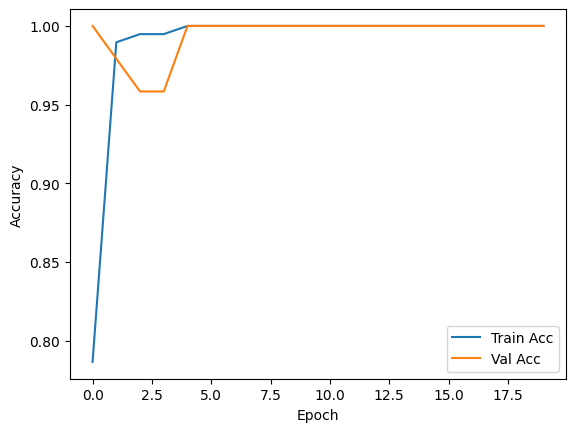

In [12]:
# Visualize training history
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Langkah 12: Menyimpan Model dan Scaler

In [13]:
# Save the trained model
import pickle

# 1. Simpan Model
# Menggunakan format .h5
model.save('day_night_model.h5')
print("✅ Model berhasil disimpan sebagai: day_night_model.h5")

# 2. Simpan Scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler berhasil disimpan sebagai: scaler.pkl")

✅ Model berhasil disimpan sebagai: day_night_model.h5
✅ Scaler berhasil disimpan sebagai: scaler.pkl
